Linear regression model (with input data from several tickers)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.metrics import r2_score

In [ ]:
def read_data(ticker):
    """
    Read logarithmic returns from file

    :ticker: ticker of continious futures
    """
    # You need to insert the path to the data file
    data = pd.read_csv(ticker+'.csv', index_col = 'date')
    #All datasets for this course are available at this link:
    #https://drive.google.com/drive/folders/1mhbVjuwNZGX9nmZuCxJStBmraF3HIzio?usp=sharing

    # Parse timestamps
    data.index = pd.to_datetime(data.index, format = "%Y-%m-%d %H:%M:%S")

    return data

In [ ]:
data = read_data('NQ')
data2 = read_data('YM')

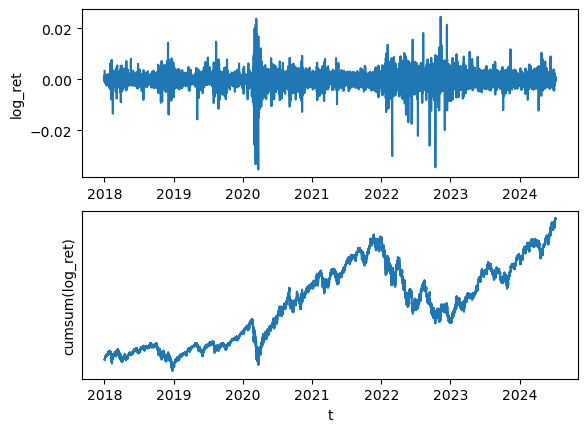

In [ ]:
# Let's draw graphs
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(data)
ax1.set_ylabel('log_ret')

ax2.plot(data.cumsum())
ax2.set_yticks([])
ax2.set_ylabel('cumsum(log_ret)')
_ = ax2.set_xlabel('t')

Functions for calculating standard statistics on the daily equity curve:

In [ ]:
days_in_year = 365.25

def Return(rets):
    """
    Annual return estimate

    :rets: daily returns of the strategy
    """
    return np.mean(rets)*days_in_year


def Volatility(rets):
    """
    Estimation of annual volatility

    :rets: daily returns of the strategy
    """
    return np.std(rets)*np.sqrt(days_in_year)


def SharpeRatio(rets):
    """
    Estimating the annual Sharpe ratio

    :rets: daily returns of the strategy
    """
    volatility = Volatility(rets)
    if (volatility>0):
        return Return(rets)/volatility
    else:
        return float('NaN')

def statistics_calc(rets, bh, name = '_', plot = False):
    """
    Draws a graph of portfolio equity and calculates annual Sharpe ratios, profitability and volatility

    :rets: daily returns of the strategy
    """
    sharpe = SharpeRatio(rets)
    ret = Return(rets)
    vol = Volatility(rets)
    if plot:
        plt.plot(rets.cumsum(), label = 'strategy')
        plt.plot(bh.cumsum(), label = 'buy & hold')
        plt.xlabel('t')
        plt.legend()
        print('Sharpe ratio = %0.2f'%sharpe)
        print('Annual Return = %0.2f'%ret)
        print('Annual Std = %0.2f'%vol)
    return pd.DataFrame([[sharpe, ret, vol]], columns = ['Sharpe ratio', 'Annual return', 'Volatility'], index = [name])

Features generation:

In [ ]:
def make_features(data, pref = ''):
    features = pd.DataFrame(index = data.index)

    # Estimating asset volatility using double exponential moving average:
    features['absRet'] = np.abs(data['log_ret'])
    features['EmaAbsRet'] = features['absRet'].ewm(20).mean().shift(1)*np.sqrt(20)
    features['vol'] = features['EmaAbsRet'].ewm(200).mean()*np.sqrt(200)+0.000000001

    features['normalized_log_ret'] = data['log_ret']/features['vol']

    periods = (np.logspace(2.0, 4.0, num = 10)).astype(int)
    print(periods)

    for period in periods:
        features['f_'+pref+str(period)] = (np.sqrt(period)*features['normalized_log_ret'].rolling(window = period, win_type = 'triang').mean()).shift(1)
    features = features.dropna()
    return features

Creating and training a linear regression model (Ridge)

[  100   166   278   464   774  1291  2154  3593  5994 10000]
[  100   166   278   464   774  1291  2154  3593  5994 10000]
Sharpe ratio = 1.37
Annual Return = 0.22
Annual Std = 0.16


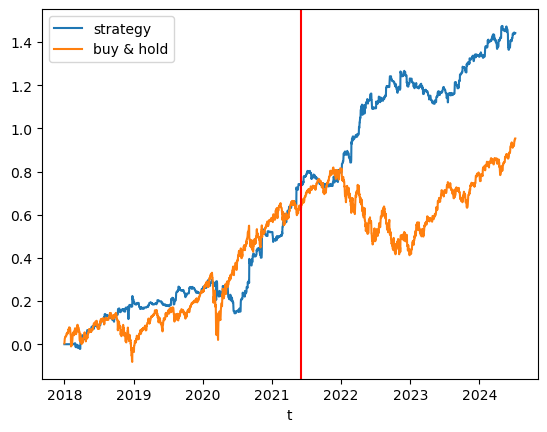

In [ ]:
in_sample_start = '2018-01-01'
in_sample_end = '2021-06-01'

features = make_features(data)

features2 = make_features(data2, pref = 's')
features2 = features2[features2.columns[np.array([name[:2] for name in features.columns]) == 'f_']]
features = features.merge(features2, how = 'left', left_index = True, right_index = True).ffill()

y = features['normalized_log_ret']
X = features[features.columns[np.array([name[:2] for name in features.columns]) == 'f_']]

X_train = X.loc[in_sample_start:in_sample_end]
y_train = y.loc[in_sample_start:in_sample_end]
X_test = X.loc[in_sample_end:]
y_test = y.loc[in_sample_end:]

clf = Ridge(alpha = 500, fit_intercept = False)

clf.fit(X_train, y_train)

features['position'] = clf.predict(X)/ clf.predict(X_train).std()

features['position'] = features['position'].ewm(alpha = 0.1).mean()

# We trade whole lots
features['position'] = features['position'].fillna(0).astype(int)

# Maximum position limit
pos_limit = 4
features.loc[features.index[features['position']>pos_limit], 'position'] = pos_limit
features.loc[features.index[features['position']<-pos_limit], 'position'] = -pos_limit

slippage = 0.00001

# We calculate the equity curve and convert it to a daily timeframe to calculate basic statistics
eq = (data['log_ret']*features['position']-slippage*features['position'].diff().abs()
     ).fillna(0).resample('1D').agg('sum')
bh = data['log_ret'].fillna(0).resample('1D').agg('sum')

# We calculate statistics and save the result
stats = statistics_calc(eq, bh, plot = True)

plt.axvline(x = datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date(), color = 'red')

Calculate statistics on test data:

Sharpe ratio = 1.41
Annual Return = 0.23
Annual Std = 0.16


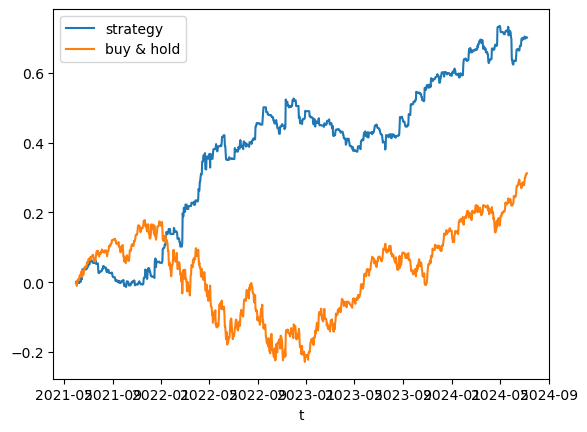

In [ ]:
stats = statistics_calc(eq[datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date():], bh[datetime.datetime.strptime(in_sample_end, "%Y-%m-%d").date():], plot = True)

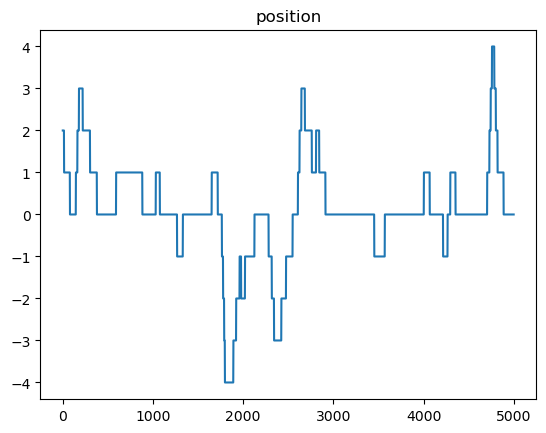

In [ ]:
plt.plot(np.arange(5000), features['position'][-5000:])
_ = plt.title('position')

Visualization of different levels of regularization

In [ ]:
from sklearn import linear_model

n_alphas = 100
alphas = np.logspace(-1, 5, n_alphas)

coefs = []
r2_train = []
r2_test = []
for a in alphas:
    ridge = linear_model.Ridge(alpha = a, fit_intercept = False, solver = 'saga')
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    r2_train.append(r2_score(y_train, ridge.predict(X_train)))
    r2_test.append(r2_score(y_test, ridge.predict(X_test)))

[0.1        0.1149757  0.13219411 0.15199111 0.17475284 0.2009233
 0.23101297 0.26560878 0.30538555 0.35111917]


(199526.2314968879,
 0.05011872336272722,
 -0.015777367038436088,
 0.010746062369889564)

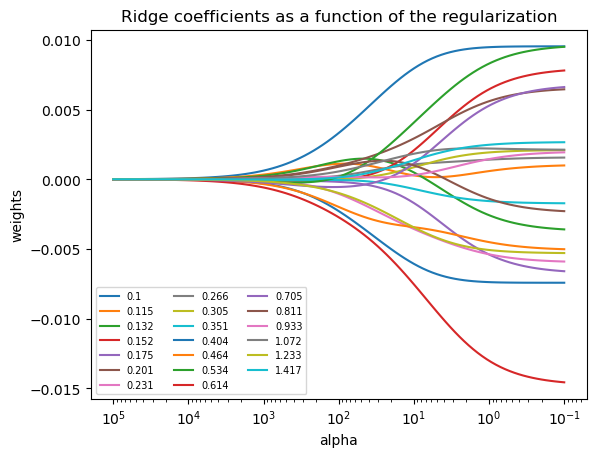

In [ ]:
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1]) # Reverse axis
plt.xlabel("alpha")
plt.ylabel("weights")
plt.legend(np.round(alphas, decimals = 3), loc = 'lower left', prop = {'size': 7}, ncol = 3)
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")

(199526.2314968879,
 0.05011872336272722,
 -3.900470532033906e-05,
 0.00011754334236344088)

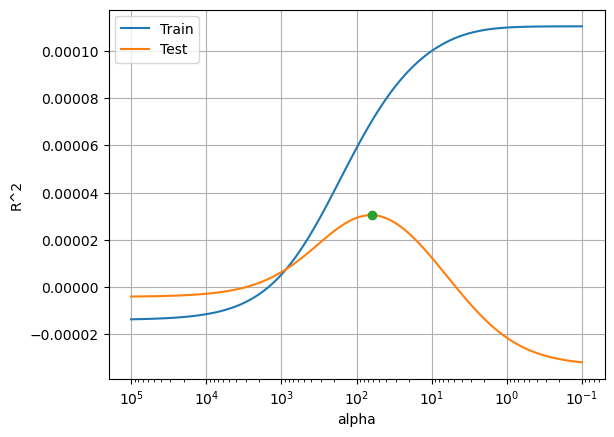

In [ ]:
ax = plt.gca()

ax.plot(alphas, r2_train, label = 'Train')
ax.plot(alphas, r2_test, label = 'Test')

ax.plot(alphas[np.argmax(r2_test)], r2_test[np.argmax(r2_test)], 'o')

ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1]) # Reverse axis

ax.legend()
ax.grid()

plt.xlabel("alpha")
plt.ylabel("R^2")
plt.axis("tight")

Additional exercises and research topics:

Improve the strategy by feature engineering and using other regression models. Try other formulas for the target position calculation. Conduct detailed testing on various instruments using the walk-forward approach and stability analysis.